In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv("english_hate_speech.csv")

In [3]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [6]:
(df
     .groupby("class")
     .agg(
        hate_speech_count=("hate_speech", "mean"),
        offensive_language_count=("offensive_language", "mean"),
        neither_count=("neither", "mean"),
     )
     .round(1)
)

,hate_speech_count,offensive_language_count,neither_count
class,,,
0,2.3,0.8,0.1
1,0.2,3.0,0.1
2,0.1,0.3,2.8


In [7]:
df = (df
    .drop(columns=["count", "hate_speech", "offensive_language", "neither"])
)
df.head()


,Unnamed: 0,class,tweet
0,0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
df = (df
    .drop(columns=["Unnamed: 0"])
)
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [9]:
df["class"].value_counts(dropna=False, normalize=True).sort_index()

class
0    0.057701
1    0.774321
2    0.167978
Name: proportion, dtype: float64

In [10]:
df = (df
    .assign(
        class_=df["class"].map({
            0:1,
            1:1,
            2:0
        })
    )
    .drop(columns=["class"])
    .rename(columns={"class_": "class"})
)

df["class"].value_counts(dropna=False, normalize=True).sort_index()

class
0    0.167978
1    0.832022
Name: proportion, dtype: float64

In [11]:
class_map = {
    0: "neutral", 
    1: "offensive and hate speech"
}

In [13]:
import re
def remove_urls(text, replacement_text=""):
    """Remove URLs from string."""
    pattern = re.compile(r"https?://\S+|www\.\S+")
    return pattern.sub(replacement_text, text)


def remove_twitter_handles(text, replacement_text=""):
    """Remove twitter handles from string."""
    pattern = re.compile(r"@[\w]+")
    return pattern.sub(replacement_text, text)


def remove_twitter_rt(text, replacement_text=""):
    """Remove twitter RTs from string."""
    pattern = re.compile(r"^RT|\s+RT\s+")
    return pattern.sub(replacement_text, text)


def remove_alphanumerics(text, replacement_text=" "):
    """Remove alphanumerics from string but leave single quote be."""
    pattern = re.compile(r"[^A-Za-z0-9']+")
    return pattern.sub(replacement_text, text)


def remove_multiple_whitespaces(text, replacement_text=" "):
    """Remove multiple whitespaces from string."""
    pattern = re.compile(r"\s{2,}")
    return pattern.sub(replacement_text, text)


def decode_html_character_references(text):
    """Decode HTML chacarters in string, e.g. &#38; and &amp;."""
    import html
    return html.unescape(text)


df = (df
    .assign(
        tweet_clean=lambda df_: (df_["tweet"]
            .apply(decode_html_character_references)                                 
            .apply(remove_twitter_handles)
            .apply(remove_twitter_rt)
            .apply(remove_urls)
            .apply(remove_alphanumerics)
            .apply(remove_multiple_whitespaces)
            .str.strip()
        )
    )
)

df.tail()

,tweet,class,tweet_clean
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1,you's a muthaf in lie right His TL is trash No...
24779,"you've gone and broke the wrong heart baby, an...",0,you've gone and broke the wrong heart baby and...
24780,young buck wanna eat!!.. dat nigguh like I ain...,1,young buck wanna eat dat nigguh like I aint fu...
24781,youu got wild bitches tellin you lies,1,youu got wild bitches tellin you lies
24782,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...,0,Ruffled Ntac Eileen Dahlia Beautiful color com...


In [14]:
import subprocess
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def tokenize(doc):
    return word_tokenize(doc)


def remove_stopwords(doc):
    stops = set(stopwords.words("english"))
    stops.add("rt")
    return [token for token in doc if token not in stops]


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"ain\'t", "are not", phrase)
    phrase = re.sub(r"shan\'t", "shall not", phrase)
    phrase = re.sub(r"ma\'am", "maam", phrase)
    phrase = re.sub(r"y\'all", "you all", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

lemmatizer = WordNetLemmatizer()

df = (df
    .assign(
        tweet_preprocessed=lambda df_: (
            df_["tweet_clean"]
            .str.lower()
            .apply(lambda doc: [decontracted(word) for word in doc.split(" ")])
            .apply(lambda doc: [lemmatizer.lemmatize(word) for word in doc])
            .apply(lambda doc: " ".join(doc))
            .apply(word_tokenize)
            .apply(remove_stopwords)
       )
    )
)

df.sample(5)

,tweet,class,tweet_clean,tweet_preprocessed
7061,@socass_ Patrick you ain't nottin but a hood N...,1,Patrick you ain't nottin but a hood Nigga top ...,"[patrick, nottin, hood, nigga, top, bitch, nigga]"
18439,RT @_danieebro: all these bitches fake if you ...,1,all these bitches fake if you ask me,"[bitch, fake, ask]"
23568,always okay to bring your ho to the barbershop...,1,always okay to bring your ho to the barbershop...,"[always, okay, bring, ho, barbershop, though, ..."
2375,"@AdamBaldwin Really?? Bro, that retard @SenTed...",1,Really Bro that retard even missed the point o...,"[really, bro, retard, even, missed, point, gre..."
14652,RT @Charlie_Gru: My wife's doing some sort of ...,0,My wife's doing some sort of boot scootin whil...,"[wife, sort, boot, scootin, singing, little, l..."


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import namedtuple

In [17]:

y = df["class"].values
x = df["tweet_preprocessed"].values
x = [(" ").join(doc) for  doc in x]

x = np.asarray(x)
y = np.asarray(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=8)

print(len(x_train), len(y_train))
print(len(x_test), len(y_test))


22304 22304
2479 2479


In [18]:
def return_score(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0.0)
    recall = recall_score(y_true, y_pred, average="weighted")
    matrix = confusion_matrix(y_true, y_pred, normalize="true")
    Scores = namedtuple("Scores", ["acc", "f1", "precision", "recall", "matrix"])
    return Scores(acc, f1, precision, recall, matrix)

In [19]:
dummy = DummyClassifier()
logistic = LogisticRegression(max_iter=1_000, random_state=8)
svc = LinearSVC(max_iter=1_000, random_state=8)
sgd = SGDClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()


models = [
    dummy, 
    logistic, 
    sgd,
    dt, 
    rf, 
    xgb,
]

for model in models:
    model_name = model.__class__.__name__
    model_scores = []

    print(model_name)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=8)
    for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):

        print(f"\tFold {i}")

        # create train and val subset
        x_train_count = x_train[train_index]
        y_train_count = y_train[train_index]
        x_val_count = x_train[val_index]
        y_val_count = y_train[val_index]

        # oversample minority class in train set to deal with class imbalance
        # not oversample the val set to keep it untouched
        ros = RandomOverSampler(random_state=42)
        x_train_count, y_train_count = ros.fit_resample(x_train_count.reshape(-1, 1), y_train_count)
        x_train_count = x_train_count.flatten()
        
        if model_name != "DummyClassifier":
            # vectorize
            vectorizer = CountVectorizer()
            vectorizer.fit(x_train_count)
            x_train_count = vectorizer.transform(x_train_count)
            x_val_count = vectorizer.transform(x_val_count)
            
        # fit and predict
        model.fit(x_train_count, y_train_count)
        y_pred = model.predict(x_val_count)
        scores_this_fold = return_score(y_val_count, y_pred)
        model_scores.append(scores_this_fold)

    # print scores
    mean_acc = np.asarray([score.acc for score in model_scores]).mean()
    mean_f1 = np.asarray([score.f1 for score in model_scores]).mean()
    mean_precision = np.asarray([score.precision for score in model_scores]).mean()
    mean_recall = np.asarray([score.recall for score in model_scores]).mean()
    print(f"\tAcc: {mean_acc: .5f} | F1: {mean_f1: .5f} | Precision : {mean_precision: .5f} | Recall: {mean_recall: .5f}")

DummyClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.16800 | F1:  0.04833 | Precision :  0.02822 | Recall:  0.16800
LogisticRegression
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.94884 | F1:  0.95051 | Precision :  0.95485 | Recall:  0.94884
SGDClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.94987 | F1:  0.95108 | Precision :  0.95367 | Recall:  0.94987
DecisionTreeClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.94364 | F1:  0.94435 | Precision :  0.94546 | Recall:  0.94364
RandomForestClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.94987 | F1:  0.95045 | Precision :  0.95138 | Recall:  0.94987
XGBClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.94790 | F1:  0.94999 | Precision :  0.95622 | Recall:  0.94790


In [22]:
xgb = XGBClassifier(objective="multi:softmax", num_class=2,random_state=24)
vectorizer = CountVectorizer()
ros = RandomOverSampler(random_state=42)

# resample
x_train_res, y_train_res = ros.fit_resample(x_train.reshape(-1, 1), y_train)
x_train_res = x_train_res.flatten()

# vectorize
vectorizer.fit(x_train_res)
x_train_vectorized = vectorizer.transform(x_train_res)
x_test_vectorized = vectorizer.transform(x_test)

# fit and predict
xgb.fit(x_train_vectorized, y_train_res)
y_pred = xgb.predict(x_test_vectorized)
scores = return_score(y_test, y_pred)

print(f"Acc: {scores.acc: .5f} | F1: {scores.f1: .5f} | Precision : {scores.precision: .5f} | Recall: {scores.recall: .5f}")

Acc:  0.95119 | F1:  0.95312 | Precision :  0.95904 | Recall:  0.95119


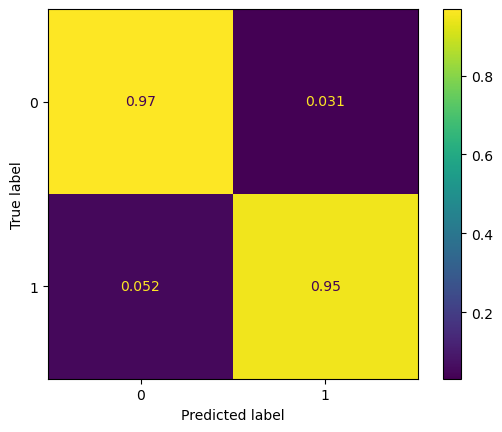

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")
plt.show()

In [43]:
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer

MyTF_IDF = TfidfVectorizer(analyzer='char_wb',ngram_range=(1,3))
ModelXGB = Pipeline([('tfidf' , MyTF_IDF) , ('XGB', xgb.XGBClassifier(objective="multi:softmax", num_class=2, random_state=123)
)])
ModelXGB.fit(x_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char_wb', ngram_range=(1, 3))),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, num_class=2,
                               num_parallel_tree=None, ...))])

In [44]:
from sklearn.metrics import classification_report

PredictionXGB_2 = ModelXGB_2.predict(x_test)
print("Using XGB : ")
print(classification_report(y_test , PredictionXGB))
print("*"*20)
print()

Using XGB : 
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       416
           1       0.98      0.96      0.97      2063

    accuracy                           0.95      2479
   macro avg       0.90      0.92      0.91      2479
weighted avg       0.95      0.95      0.95      2479

********************



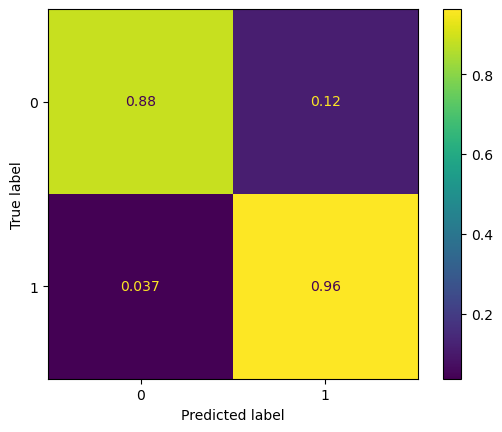

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, PredictionXGB, normalize="true")
plt.show()

In [46]:
import joblib

In [48]:
joblib.dump(ModelXGB, 'EN_ModelXGB.pkl')

['EN_ModelXGB.pkl']